In [1]:
import mbfit
from mbfit.polynomials import generate_input_poly
from mbfit.polynomials.generate_poly import PolynomialGenerator
from mbfit.polynomials. filters import Filter
from mbfit import mbfit
from mbfit.utils import files
import numpy as np
import os
from sklearn.base import BaseEstimator
import shutil
import time
from subprocess import Popen, PIPE

/home/zluo/MB_Fit/mbfit/utils/settings_reader.py:278: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if element is not "":
/home/zluo/MB_Fit/mbfit/molecule/fragment.py:82: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if digits[0] is '%':
/home/zluo/MB_Fit/mbfit/molecule/fragment.py:108: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if char is '(':
/home/zluo/MB_Fit/mbfit/molecule/fragment.py:110: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if char is ')':
/home/zluo/MB_Fit/mbfit/polynomials/molecule_in_parser.py:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if char is '(':
/home/zluo/MB_Fit/mbfit/polynomials/molecule_in_parser.py:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif char is ')':
/home/zluo/MB_Fit/mbfit/polynomials/molecule_in_parser.py:38: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif char is '_' and num_open_parens == 0:
/home/zluo/MB_Fit/mbfit/polynomials/molecule_in_parser.p

In [4]:
import pandas as pd

In [7]:
class TSCCFit():

    def __init__(self, script, w_p, name):
        self.script = script
        self.w_p = w_p
        self.name = name

    def run(self):
        inp = """#!/bin/bash

#PBS -N job:{name}
#PBS -q glean
#PBS -l walltime=8:00:00,nodes=1:ppn=16
#PBS -e test.err
#PBS -o test.out
#PBS -M zluo@ucsd.edu

echo "job has run!"

module load netcdf
module load gsl
module load intel

source ~/anaconda3/etc/profile.d/conda.sh
conda activate

cd $PBS_O_WORKDIR

source {script}
        
""".format(script=self.script, name=self.name)

        job_path = self.script + ".job"
        with open(job_path, "w") as job_file:
            job_file.write(inp)
            
        os.chdir(self.w_p)

        with Popen(["qsub", job_path], stdout=PIPE) as qsub:
            for line in qsub.stdout:
                self.job_id = int(line.split(b'.')[0])

    def is_done(self):

        with Popen(["qstat", "-u", "zluo"], stdout=PIPE) as qstat:
            for i, line in enumerate(qstat.stdout):

                if i > 4:
                    toks = line.split()
                    job_id = int(toks[0].split(b'.')[0])
                    if job_id == self.job_id:
                        print("Toks: ", toks)
                        if toks[9] == b'R' or toks[9] == b'Q' or toks[9] == b'E':
                            return False

        return True

In [8]:
class RFEEstimator(BaseEstimator):
    import mbfit
    from mbfit.polynomials import generate_input_poly
    from mbfit.polynomials.generate_poly import PolynomialGenerator
    from mbfit.polynomials. filters import Filter
    from mbfit import mbfit
    
    # the constructor with all information
    def __init__(self, sym_str, order, setting_path="setting.ini", poly_in_path="poly.in", poly_log_path="poly.log", config_path="config.ini", poly_path="poly", fit_dir_path="test_fit_code", fits_path="fits"):
        self.sym_str = sym_str
        self.order = order
        self.setting_path = setting_path
        self.poly_in_path = poly_in_path
        self.poly_log_path = poly_log_path
        self.config_path = config_path
        self.poly_path = poly_path
        self.fit_dir_path = fit_dir_path
        self.fits_path = fits_path
        
        poly = PolynomialGenerator(self.setting_path)
        result = poly.get_monomials_and_variables(self.poly_in_path, self.order, self.poly_log_path)
        self.monos = result[0]
        self.variables = result[1]
        self.perms = result[2]
        self.poly = poly
    
    
    # get monos
    def get_monos(self):
        return self.monos
    
    
    # get variables 
    def get_variables(self):
        return self.variables
    
    
    # get perms
    def get_perms(self):
        return self.perms
        
        
    # fit method
    # X=monos
    # y=training_set_file
    def fit(self, X, y):
        y = "2b.xyz"
        X = get_X(self.monos, X)
        
        iter_n = 0
        
        while os.path.exists(self.poly_path + str(iter_n)):
            iter_n += 1    
        
        this_poly_path = self.poly_path + str(iter_n)
        this_fit_dir_path = self.fit_dir_path + str(iter_n)
        this_fits_path = self.fits_path + str(iter_n)
        files.init_directory(this_poly_path)
        files.init_directory(this_fit_dir_path)
        files.init_directory(this_fits_path)
        shutil.copyfile(self.poly_log_path, os.path.join(this_poly_path, 'poly.log'))
        with open(os.path.join(this_poly_path, 'poly.log'), mode='r') as log:
            log_lst = log.readlines()
                
        log_lst[-1] = ' Total number of terms: ' + str(len(X)) + '\n'
            
        with open(os.path.join(this_poly_path, 'poly.log'), mode='w') as log:
            for l in log_lst:
                log.write(l)
        
        #Save monos to csv
        df = pd.DataFrame([x.get_degrees() for x in X], columns=header)
        df.to_csv("n1_monos_" + str(iter_n) + ".csv")
        
        self.poly.write_cpp_files(X, self.variables, self.perms, this_poly_path, generate_direct_gradients=True)
        mbfit.generate_mbnrg_fitting_code(self.setting_path, self.config_path, self.poly_in_path, this_poly_path, self.order, this_fit_dir_path, use_direct = True)
        mbfit.compile_fit_code(self.setting_path, this_fit_dir_path)
        mbfit.prepare_fits(self.setting_path, this_fit_dir_path, y, this_fits_path)
        
        queue = list()
        #create 10 instances of TSCCFit
        for i in range(1, 11):
            script_path = "/home/zluo/MB-Fit_dev/" + this_fits_path + "/fit{}/run_fit.sh".format(i)
            working_path = "/home/zluo/MB-Fit_dev/" + this_fits_path + "/fit{}".format(i)
            TSCC = TSCCFit(script_path, working_path, "TSCC{}".format(i))
            queue.append(TSCC)
            
        for TSCC in queue:
            TSCC.run()
            
        for TSCC in queue:
            while not TSCC.is_done():
                time.sleep(20)
        
        os.chdir("/home/zluo/MB-Fit_dev")
        mbfit.retrieve_best_fit(self.setting_path, this_fits_path)
        self.coef_ = read_coef(this_fits_path)

In [9]:
def get_X(all_monos, X):
    out = []
    idx_lst = list(X[0]) # a list of index to indicate which features to use
    for idx in idx_lst:
        out.append(all_monos[idx])
            
    return out

In [10]:
def read_coef(fits_path):
    out = []
    with open(os.path.join(fits_path, "best_fit/fit-2b.cdl")) as f:
        while True:
            l = f.readline()
            if l[:4] == 'poly':
                break
        
        while l.split()[0][-1] != ';':
            l = f.readline()
            out.append(float(l.split()[0][:-1]))
        
    return np.array(out)

In [11]:
est = RFEEstimator("A1B2X2,A1B2X2", 4)

Parsing polynomial input file poly.in...
Atom names ['A1a', 'B1a', 'B2a', 'X1a', 'X2a', 'A2b', 'B3b', 'B4b', 'X3b', 'X4b']
File ./poly.log already exists, moving existing ./poly.log to ./poly.log.backup-1 to make way for new file.
Finding permutations...
Generating terms up to degree 4...
|====================================================================================================|
8 possible degree 1 terms, now filtering them...
There were 6 accepted degree 1 terms.
70 possible degree 2 terms, now filtering them...
There were 63 accepted degree 2 terms.
505 possible degree 3 terms, now filtering them...
There were 491 accepted degree 3 terms.
3260 possible degree 4 terms, now filtering them...
There were 593 accepted degree 4 terms.
There were 1153 accepted terms over all


In [12]:
monos = est.get_monos()
variables = est.get_variables()
global header
header = []
for v in variables:
    to_add = v.atom1_name + ", " + v.atom1_fragment + ", " + v.atom2_name + ", " + v.atom2_fragment + ", " + v.category
    header.append(to_add)

In [13]:
X = np.array([n for n in range(len(monos))]).reshape(1, -1)

In [14]:
y = [1]

In [15]:
from sklearn.feature_selection import RFE

In [16]:
estimator = RFEEstimator("A1B2X2,A1B2X2", 4)

Parsing polynomial input file poly.in...
Atom names ['A1a', 'B1a', 'B2a', 'X1a', 'X2a', 'A2b', 'B3b', 'B4b', 'X3b', 'X4b']
File ./poly.log already exists, moving existing ./poly.log to ./poly.log.backup-2 to make way for new file.
Finding permutations...
Generating terms up to degree 4...
|====================================================================================================|
8 possible degree 1 terms, now filtering them...
There were 6 accepted degree 1 terms.
70 possible degree 2 terms, now filtering them...
There were 63 accepted degree 2 terms.
505 possible degree 3 terms, now filtering them...
There were 491 accepted degree 3 terms.
3260 possible degree 4 terms, now filtering them...
There were 593 accepted degree 4 terms.
There were 1153 accepted terms over all


In [17]:
selector = RFE(estimator, n_features_to_select=600, step=100)

In [18]:
selector = selector.fit(X, y)

Parsing polynomial input file poly.in...
Atom names ['A1a', 'B1a', 'B2a', 'X1a', 'X2a', 'A2b', 'B3b', 'B4b', 'X3b', 'X4b']
File ./poly.log already exists, moving existing ./poly.log to ./poly.log.backup-3 to make way for new file.
Finding permutations...
Generating terms up to degree 4...
|====================================================================================================|
8 possible degree 1 terms, now filtering them...
There were 6 accepted degree 1 terms.
70 possible degree 2 terms, now filtering them...
There were 63 accepted degree 2 terms.
505 possible degree 3 terms, now filtering them...
There were 491 accepted degree 3 terms.
3260 possible degree 4 terms, now filtering them...
There were 593 accepted degree 4 terms.
There were 1153 accepted terms over all
Writing .h and .maple polynomial files in directory poly0...
Writing gradients...
|====================================================================================================|
Writing terms...
|=====

Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:11:13']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:11:33']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:11:54']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:12:14']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:12:34']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:12:54']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:13:14']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16',

Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:32:39']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:32:59']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:33:19']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:33:39']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:33:59']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:34:19']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:34:39']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16',

Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:54:05']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:54:25']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'R', b'00:54:45']
Toks:  [b'28204011.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'12160', b'1', b'16', b'--', b'08:00:00', b'C', b'--']
Toks:  [b'28204012.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'7471', b'1', b'16', b'--', b'08:00:00', b'R', b'00:55:01']
Toks:  [b'28204012.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'7471', b'1', b'16', b'--', b'08:00:00', b'R', b'00:55:21']
Toks:  [b'28204012.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'7471', b'1', b'16', b'--', b'08:00:00', b'R', b'00:55:41']
Toks:  [b'28204012.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'7471', b'1', b'16', b'--', b'

Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:14:42']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:15:02']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:15:22']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:15:42']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:16:02']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:16:23']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:16:43']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16',

Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:36:10']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:36:30']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:36:50']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:37:10']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:37:30']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:37:50']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:38:10']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16',

Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:57:36']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:57:56']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:58:16']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:58:36']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:58:56']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:59:17']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16', b'--', b'08:00:00', b'R', b'01:59:37']
Toks:  [b'28204013.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'25262', b'1', b'16',

Toks:  [b'28204015.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC5', b'18812', b'1', b'16', b'--', b'08:00:00', b'R', b'02:18:33']
Toks:  [b'28204015.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC5', b'18812', b'1', b'16', b'--', b'08:00:00', b'R', b'02:18:53']
Toks:  [b'28204015.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC5', b'18812', b'1', b'16', b'--', b'08:00:00', b'R', b'02:19:13']
Toks:  [b'28204015.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC5', b'18812', b'1', b'16', b'--', b'08:00:00', b'R', b'02:19:33']
Toks:  [b'28204015.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC5', b'18812', b'1', b'16', b'--', b'08:00:00', b'R', b'02:19:53']
Toks:  [b'28204015.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC5', b'18812', b'1', b'16', b'--', b'08:00:00', b'R', b'02:20:13']
Toks:  [b'28204015.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC5', b'18812', b'1', b'16', b'--', b'08:00:00', b'R', b'02:20:33']
Toks:  [b'28204015.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC5', b'18812', b'1', b'16',

Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'0', b'1', b'16', b'--', b'08:00:00', b'R', b'00:00:42']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:01:02']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:01:22']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:01:42']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:02:02']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:02:22']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:02:42']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'-

Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:22:05']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:22:25']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:22:45']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:23:06']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:23:26']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:23:46']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:24:06']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16',

Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:43:30']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:43:50']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:44:10']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:44:30']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:44:50']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:45:10']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'00:45:30']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16',

Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:04:55']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:05:15']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:05:35']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:05:55']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:06:15']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:06:35']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:06:56']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16',

Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:26:19']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:26:39']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:26:59']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:27:19']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:27:39']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:27:59']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:28:19']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16',

Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:47:43']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:48:03']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:48:23']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:48:43']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:49:03']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:49:23']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16', b'--', b'08:00:00', b'R', b'01:49:43']
Toks:  [b'28205322.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'27394', b'1', b'16',

Toks:  [b'28205329.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC4', b'13383', b'1', b'16', b'--', b'08:00:00', b'R', b'02:08:31']
Toks:  [b'28205329.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC4', b'13383', b'1', b'16', b'--', b'08:00:00', b'R', b'02:08:51']
Toks:  [b'28205329.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC4', b'13383', b'1', b'16', b'--', b'08:00:00', b'R', b'02:09:11']
Toks:  [b'28205329.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC4', b'13383', b'1', b'16', b'--', b'08:00:00', b'R', b'02:09:31']
Toks:  [b'28205329.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC4', b'13383', b'1', b'16', b'--', b'08:00:00', b'R', b'02:09:52']
Toks:  [b'28205329.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC4', b'13383', b'1', b'16', b'--', b'08:00:00', b'R', b'02:10:12']
Toks:  [b'28205329.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC4', b'13383', b'1', b'16', b'--', b'08:00:00', b'C', b'--']
Toks:  [b'28205331.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC6', b'10799', b'1', b'16', b'--'

Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16', b'--', b'08:00:00', b'R', b'02:29:00']
Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16', b'--', b'08:00:00', b'R', b'02:29:20']
Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16', b'--', b'08:00:00', b'R', b'02:29:40']
Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16', b'--', b'08:00:00', b'R', b'02:30:00']
Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16', b'--', b'08:00:00', b'R', b'02:30:20']
Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16', b'--', b'08:00:00', b'R', b'02:30:40']
Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16', b'--', b'08:00:00', b'R', b'02:31:00']
Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16',

Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16', b'--', b'08:00:00', b'R', b'02:50:24']
Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16', b'--', b'08:00:00', b'R', b'02:50:44']
Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16', b'--', b'08:00:00', b'R', b'02:51:04']
Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16', b'--', b'08:00:00', b'R', b'02:51:24']
Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16', b'--', b'08:00:00', b'R', b'02:51:44']
Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16', b'--', b'08:00:00', b'R', b'02:52:04']
Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16', b'--', b'08:00:00', b'R', b'02:52:24']
Toks:  [b'28205332.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC7', b'22243', b'1', b'16',

Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'0', b'1', b'16', b'--', b'08:00:00', b'R', b'00:00:05']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'0', b'1', b'16', b'--', b'08:00:00', b'R', b'00:00:25']
Toks:  [b'28206677.tsc

Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'00:19:28']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'00:19:48']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'00:20:08']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'00:20:28']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'00:20:48']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'00:21:08']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'00:21:28']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16',

Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'00:40:52']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'00:41:12']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'00:41:32']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'00:41:52']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'00:42:12']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'00:42:32']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'00:42:53']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16',

Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:02:16']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:02:36']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:02:56']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:03:16']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:03:36']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:03:56']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:04:16']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16',

Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:23:39']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:23:59']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:24:19']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:24:39']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:24:59']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:25:19']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:25:39']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16',

Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:45:03']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:45:23']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:45:43']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:46:03']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:46:23']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:46:43']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16', b'--', b'08:00:00', b'R', b'01:47:03']
Toks:  [b'28206677.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'17894', b'1', b'16',

Compiling fit code...
Fit code compilation successful!
Succesfully created fit folder fit1.
Succesfully created fit folder fit2.
Succesfully created fit folder fit3.
Succesfully created fit folder fit4.
Succesfully created fit folder fit5.
Succesfully created fit folder fit6.
Succesfully created fit folder fit7.
Succesfully created fit folder fit8.
Succesfully created fit folder fit9.
Succesfully created fit folder fit10.
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'

Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16', b'--', b'08:00:00', b'R', b'00:13:52']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16', b'--', b'08:00:00', b'R', b'00:14:12']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16', b'--', b'08:00:00', b'R', b'00:14:32']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16', b'--', b'08:00:00', b'R', b'00:14:52']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16', b'--', b'08:00:00', b'R', b'00:15:12']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16', b'--', b'08:00:00', b'R', b'00:15:32']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16', b'--', b'08:00:00', b'R', b'00:15:52']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16',

Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16', b'--', b'08:00:00', b'R', b'00:35:16']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16', b'--', b'08:00:00', b'R', b'00:35:36']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16', b'--', b'08:00:00', b'R', b'00:35:56']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16', b'--', b'08:00:00', b'R', b'00:36:16']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16', b'--', b'08:00:00', b'R', b'00:36:36']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16', b'--', b'08:00:00', b'R', b'00:36:56']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16', b'--', b'08:00:00', b'R', b'00:37:16']
Toks:  [b'28207791.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'14960', b'1', b'16',

Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16', b'--', b'08:00:00', b'R', b'00:56:15']
Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16', b'--', b'08:00:00', b'R', b'00:56:35']
Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16', b'--', b'08:00:00', b'R', b'00:56:55']
Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16', b'--', b'08:00:00', b'R', b'00:57:15']
Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16', b'--', b'08:00:00', b'R', b'00:57:35']
Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16', b'--', b'08:00:00', b'R', b'00:57:55']
Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16', b'--', b'08:00:00', b'R', b'00:58:15']
Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16',

Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16', b'--', b'08:00:00', b'R', b'01:17:39']
Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16', b'--', b'08:00:00', b'R', b'01:17:59']
Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16', b'--', b'08:00:00', b'R', b'01:18:19']
Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16', b'--', b'08:00:00', b'R', b'01:18:39']
Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16', b'--', b'08:00:00', b'R', b'01:18:59']
Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16', b'--', b'08:00:00', b'R', b'01:19:19']
Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16', b'--', b'08:00:00', b'R', b'01:19:39']
Toks:  [b'28207792.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC2', b'46585', b'1', b'16',

Toks:  [b'28207798.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC8', b'13831', b'1', b'16', b'--', b'08:00:00', b'R', b'01:37:57']
Toks:  [b'28207798.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC8', b'13831', b'1', b'16', b'--', b'08:00:00', b'R', b'01:38:17']
Toks:  [b'28207798.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC8', b'13831', b'1', b'16', b'--', b'08:00:00', b'R', b'01:38:37']
Toks:  [b'28207798.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC8', b'13831', b'1', b'16', b'--', b'08:00:00', b'R', b'01:38:57']
Toks:  [b'28207798.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC8', b'13831', b'1', b'16', b'--', b'08:00:00', b'R', b'01:39:17']
Toks:  [b'28207798.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC8', b'13831', b'1', b'16', b'--', b'08:00:00', b'R', b'01:39:37']
Toks:  [b'28207798.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC8', b'13831', b'1', b'16', b'--', b'08:00:00', b'R', b'01:39:57']
Toks:  [b'28207798.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC8', b'13831', b'1', b'16',

Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:01:23']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:01:43']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:02:03']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:02:23']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:02:44']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:03:04']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:03:24']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16',

Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:22:47']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:23:07']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:23:27']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:23:47']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:24:07']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:24:27']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:24:47']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16',

Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:44:11']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:44:31']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:44:51']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:45:11']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:45:31']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:45:51']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16', b'--', b'08:00:00', b'R', b'00:46:11']
Toks:  [b'28208679.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'13286', b'1', b'16',

Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16', b'--', b'08:00:00', b'R', b'01:04:48']
Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16', b'--', b'08:00:00', b'R', b'01:05:08']
Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16', b'--', b'08:00:00', b'R', b'01:05:28']
Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16', b'--', b'08:00:00', b'R', b'01:05:48']
Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16', b'--', b'08:00:00', b'R', b'01:06:08']
Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16', b'--', b'08:00:00', b'R', b'01:06:28']
Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16', b'--', b'08:00:00', b'R', b'01:06:48']
Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16',

Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16', b'--', b'08:00:00', b'R', b'01:26:12']
Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16', b'--', b'08:00:00', b'R', b'01:26:32']
Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16', b'--', b'08:00:00', b'R', b'01:26:52']
Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16', b'--', b'08:00:00', b'R', b'01:27:12']
Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16', b'--', b'08:00:00', b'R', b'01:27:32']
Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16', b'--', b'08:00:00', b'R', b'01:27:52']
Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16', b'--', b'08:00:00', b'R', b'01:28:12']
Toks:  [b'28208681.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'27746', b'1', b'16',

Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28210625.tscc-mgr7.loc

Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', b'08:00:00', b'R', b'00:15:47']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', b'08:00:00', b'R', b'00:16:07']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', b'08:00:00', b'R', b'00:16:28']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', b'08:00:00', b'R', b'00:16:48']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', b'08:00:00', b'R', b'00:17:08']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', b'08:00:00', b'R', b'00:17:28']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', b'08:00:00', b'R', b'00:17:48']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', 

Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', b'08:00:00', b'R', b'00:37:12']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', b'08:00:00', b'R', b'00:37:32']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', b'08:00:00', b'R', b'00:37:52']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', b'08:00:00', b'R', b'00:38:12']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', b'08:00:00', b'R', b'00:38:32']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', b'08:00:00', b'R', b'00:38:52']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', b'08:00:00', b'R', b'00:39:12']
Toks:  [b'28210625.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'9086', b'1', b'16', b'--', 

Toks:  [b'28210633.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC9', b'54352', b'1', b'16', b'--', b'08:00:00', b'R', b'00:30:15']
Toks:  [b'28210633.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC9', b'54352', b'1', b'16', b'--', b'08:00:00', b'R', b'00:30:35']
Toks:  [b'28210633.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC9', b'54352', b'1', b'16', b'--', b'08:00:00', b'R', b'00:30:56']
Toks:  [b'28210633.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC9', b'54352', b'1', b'16', b'--', b'08:00:00', b'R', b'00:31:16']
Toks:  [b'28210633.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC9', b'54352', b'1', b'16', b'--', b'08:00:00', b'R', b'00:31:36']
Toks:  [b'28210633.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC9', b'54352', b'1', b'16', b'--', b'08:00:00', b'R', b'00:31:56']
Toks:  [b'28210633.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC9', b'54352', b'1', b'16', b'--', b'08:00:00', b'R', b'00:32:16']
Toks:  [b'28210633.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC9', b'54352', b'1', b'16',

Toks:  [b'28210633.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC9', b'54352', b'1', b'16', b'--', b'08:00:00', b'R', b'00:51:40']
Toks:  [b'28210633.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC9', b'54352', b'1', b'16', b'--', b'08:00:00', b'R', b'00:52:01']
Toks:  [b'28210633.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC9', b'54352', b'1', b'16', b'--', b'08:00:00', b'R', b'00:52:21']
Toks:  [b'28210633.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC9', b'54352', b'1', b'16', b'--', b'08:00:00', b'R', b'00:52:41']
Toks:  [b'28210633.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC9', b'54352', b'1', b'16', b'--', b'08:00:00', b'R', b'00:53:01']
Toks:  [b'28210633.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC9', b'54352', b'1', b'16', b'--', b'08:00:00', b'C', b'--']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'00:53:16']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'-

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:12:20']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:12:40']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:13:00']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:13:20']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:13:40']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:14:01']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:14:21']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:33:24']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:33:44']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:34:04']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:34:24']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:34:44']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:35:04']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:35:24']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:54:28']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:54:48']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:55:08']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:55:28']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:55:49']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:56:09']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'01:56:29']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:15:32']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:15:52']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:16:12']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:16:32']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:16:53']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:17:13']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:17:33']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:36:36']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:36:56']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:37:16']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:37:36']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:37:56']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:38:16']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:38:37']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:57:41']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:58:01']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:58:21']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:58:41']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:59:01']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:59:21']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'02:59:41']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'03:18:44']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'03:19:04']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'03:19:24']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'03:19:44']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'03:20:04']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'03:20:24']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'03:20:45']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'03:39:48']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'03:40:08']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'03:40:28']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'03:40:48']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'03:41:08']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'03:41:29']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'03:41:49']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:00:52']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:01:12']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:01:32']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:01:52']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:02:12']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:02:33']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:02:53']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:21:57']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:22:17']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:22:37']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:22:57']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:23:17']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:23:37']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:23:58']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:43:02']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:43:22']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:43:42']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:44:02']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:44:22']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:44:42']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'04:45:03']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:04:09']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:04:29']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:04:49']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:05:09']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:05:29']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:05:49']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:06:09']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:25:14']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:25:34']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:25:54']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:26:15']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:26:35']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:26:55']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:27:15']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:46:19']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:46:39']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:46:59']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:47:19']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:47:39']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:47:59']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'05:48:19']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:07:25']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:07:45']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:08:05']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:08:25']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:08:45']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:09:05']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:09:26']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:28:33']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:28:53']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:29:13']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:29:33']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:29:53']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:30:13']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:30:33']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:49:38']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:49:58']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:50:18']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:50:38']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:50:58']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:51:18']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'06:51:39']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:10:47']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:11:07']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:11:27']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:11:47']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:12:07']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:12:28']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:12:48']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:31:54']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:32:15']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:32:35']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:32:55']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:33:15']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:33:35']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:33:55']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:53:02']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:53:22']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:53:42']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:54:02']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:54:22']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:54:42']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1', b'16', b'--', b'08:00:00', b'R', b'07:55:02']
Toks:  [b'28210634.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC10', b'11144', b'1'

Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'Q', b'--']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'--', b'1', b'16', b'--', b'08:00:00', b'R', b'00:00:05']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'0', b'1', b'16', b'--', b'08:00:00', b'R', b'00:00:21']
Toks:  [b'28215084.ts

Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16', b'--', b'08:00:00', b'R', b'00:19:26']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16', b'--', b'08:00:00', b'R', b'00:19:46']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16', b'--', b'08:00:00', b'R', b'00:20:06']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16', b'--', b'08:00:00', b'R', b'00:20:26']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16', b'--', b'08:00:00', b'R', b'00:20:46']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16', b'--', b'08:00:00', b'R', b'00:21:06']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16', b'--', b'08:00:00', b'R', b'00:21:27']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16',

Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16', b'--', b'08:00:00', b'R', b'00:40:53']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16', b'--', b'08:00:00', b'R', b'00:41:13']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16', b'--', b'08:00:00', b'R', b'00:41:33']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16', b'--', b'08:00:00', b'R', b'00:41:53']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16', b'--', b'08:00:00', b'R', b'00:42:13']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16', b'--', b'08:00:00', b'R', b'00:42:33']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16', b'--', b'08:00:00', b'R', b'00:42:53']
Toks:  [b'28215084.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC1', b'10535', b'1', b'16',

Toks:  [b'28215087.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'32270', b'1', b'16', b'--', b'08:00:00', b'R', b'01:01:49']
Toks:  [b'28215087.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'32270', b'1', b'16', b'--', b'08:00:00', b'R', b'01:02:09']
Toks:  [b'28215087.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'32270', b'1', b'16', b'--', b'08:00:00', b'R', b'01:02:29']
Toks:  [b'28215087.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'32270', b'1', b'16', b'--', b'08:00:00', b'R', b'01:02:49']
Toks:  [b'28215087.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'32270', b'1', b'16', b'--', b'08:00:00', b'R', b'01:03:09']
Toks:  [b'28215087.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'32270', b'1', b'16', b'--', b'08:00:00', b'R', b'01:03:29']
Toks:  [b'28215087.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'32270', b'1', b'16', b'--', b'08:00:00', b'E', b'08:00:00']
Toks:  [b'28215087.tscc-mgr7.loc', b'zluo', b'glean', b'job:TSCC3', b'32270', b'1', b'16',

In [33]:
def read_rmse():
    out=[]
    iter_n = 0
        
    while os.path.exists('fits' + str(iter_n)):    
        fits_path = 'fits' + str(iter_n)
        with open(os.path.join(fits_path, "best_fit/fit.log")) as f:
            while True:
                l = f.readline()
                if l[:13] == '  err[L2,low]':
                    break
            rmse = float(l[16:25])
            out.append(rmse)
        
        iter_n += 1
        
    return out

In [34]:
y = read_rmse()

In [35]:
y

[0.0576622, 0.0574074, 0.0580171, 0.0578857, 0.0586474, 0.0605115, 0.0608]

In [23]:
y_old = [0.0568707, 0.0609225, 0.0619092, 0.0676965, 0.08042, 0.119935]
y_old

[0.0568707, 0.0609225, 0.0619092, 0.0676965, 0.08042, 0.119935]

In [21]:
y1 = y[:6]
y1

[0.0568707, 0.0609225, 0.0619092, 0.0676965, 0.08042, 0.119935]

In [36]:
X = [1153 - 100*n for n in range(7)]
X

[1153, 1053, 953, 853, 753, 653, 553]

In [3]:
import matplotlib.pyplot as plt

(1153.0, 553.0)

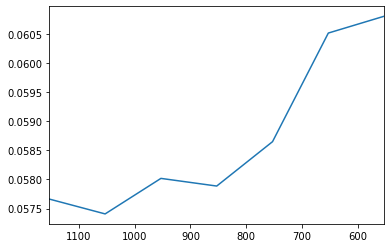

In [37]:
plt.plot(X, y)
plt.xlim(max(X),min(X))

In [5]:
df_lst = []
for i in range(7):
    df = pd.read_csv("n1_monos_"+str(i)+".csv", index_col=0)
    df_lst.append(df)

In [13]:
df_lst[0]

,"A1, a, A2, b, x-inter-A+A-0","A1, a, B1, a, x-intra-A+B-1","A1, a, B2, a, x-intra-A+B-1","A1, a, B3, b, x-inter-A+B-0","A1, a, B4, b, x-inter-A+B-0","A1, a, X3, b, x-inter-A+X-0","A1, a, X4, b, x-inter-A+X-0","A2, b, B1, a, x-inter-A+B-0","A2, b, B2, a, x-inter-A+B-0","A2, b, B3, b, x-intra-A+B-1",...,"B2, a, X4, b, x-inter-B+X-0","B3, b, B4, b, x-intra-B+B-1","B3, b, X1, a, x-inter-B+X-0","B3, b, X2, a, x-inter-B+X-0","B4, b, X1, a, x-inter-B+X-0","B4, b, X2, a, x-inter-B+X-0","X1, a, X3, b, x-inter-X+X-0","X1, a, X4, b, x-inter-X+X-0","X2, a, X3, b, x-inter-X+X-0","X2, a, X4, b, x-inter-X+X-0"
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1149,0,2,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1150,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1151,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [14]:
df_lst[1]

,"A1, a, A2, b, x-inter-A+A-0","A1, a, B1, a, x-intra-A+B-1","A1, a, B2, a, x-intra-A+B-1","A1, a, B3, b, x-inter-A+B-0","A1, a, B4, b, x-inter-A+B-0","A1, a, X3, b, x-inter-A+X-0","A1, a, X4, b, x-inter-A+X-0","A2, b, B1, a, x-inter-A+B-0","A2, b, B2, a, x-inter-A+B-0","A2, b, B3, b, x-intra-A+B-1",...,"B2, a, X4, b, x-inter-B+X-0","B3, b, B4, b, x-intra-B+B-1","B3, b, X1, a, x-inter-B+X-0","B3, b, X2, a, x-inter-B+X-0","B4, b, X1, a, x-inter-B+X-0","B4, b, X2, a, x-inter-B+X-0","X1, a, X3, b, x-inter-X+X-0","X1, a, X4, b, x-inter-X+X-0","X2, a, X3, b, x-inter-X+X-0","X2, a, X4, b, x-inter-X+X-0"
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1049,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1050,0,2,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1051,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
sum_lst = []
for df in df_lst:
    sum_lst.append(df.sum())

In [40]:
from sklearn import preprocessing

In [41]:
sum_df = pd.DataFrame(sum_lst)

In [42]:
sum_df = sum_df/sum_df.max()

In [43]:
sum_df_t = sum_df.transpose().reset_index()
sum_df_t['type'] = sum_df_t['index'].apply(lambda x: x.split(',')[-1])
sum_df_t

,index,0,1,2,3,4,5,6,type
0,"A1, a, A2, b, x-inter-A+A-0",1.0,0.903614,0.777108,0.572289,0.487952,0.240964,0.204819,x-inter-A+A-0
1,"A1, a, B1, a, x-intra-A+B-1",1.0,0.908973,0.804941,0.728218,0.630689,0.546164,0.492848,x-intra-A+B-1
2,"A1, a, B2, a, x-intra-A+B-1",1.0,0.878049,0.768293,0.621951,0.463415,0.414634,0.365854,x-intra-A+B-1
3,"A1, a, B3, b, x-inter-A+B-0",1.0,0.913462,0.846154,0.766026,0.689103,0.621795,0.589744,x-inter-A+B-0
4,"A1, a, B4, b, x-inter-A+B-0",1.0,0.904762,0.857143,0.761905,0.571429,0.476190,0.333333,x-inter-A+B-0
5,"A1, a, X3, b, x-inter-A+X-0",1.0,0.920578,0.859206,0.768953,0.685921,0.613718,0.555957,x-inter-A+X-0
6,"A1, a, X4, b, x-inter-A+X-0",1.0,1.000000,1.000000,0.800000,0.700000,0.650000,0.600000,x-inter-A+X-0
7,"A2, b, B1, a, x-inter-A+B-0",1.0,0.976744,0.895349,0.779070,0.686047,0.627907,0.593023,x-inter-A+B-0
8,"A2, b, B2, a, x-inter-A+B-0",1.0,0.948276,0.913793,0.844828,0.793103,0.655172,0.568966,x-inter-A+B-0
9,"A2, b, B3, b, x-intra-A+B-1",1.0,0.888889,0.777778,0.679012,0.592593,0.506173,0.469136,x-intra-A+B-1


In [44]:
by_type = sum_df_t.groupby('type').mean().transpose()

In [45]:
by_type

type,x-inter-A+A-0,x-inter-A+B-0,x-inter-A+X-0,x-inter-B+B-0,x-inter-B+X-0,x-inter-X+X-0,x-intra-A+B-1,x-intra-B+B-1
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.903614,0.935811,0.963478,0.887940,0.938600,0.909851,0.903353,0.889077
2,0.777108,0.878110,0.925218,0.820502,0.874445,0.805116,0.822128,0.796841
3,0.572289,0.787957,0.790155,0.728388,0.827774,0.745174,0.726046,0.708890
4,0.487952,0.684920,0.727730,0.631810,0.754820,0.655974,0.640424,0.626744
5,0.240964,0.595266,0.672180,0.555490,0.707193,0.579750,0.585493,0.517216
6,0.204819,0.521266,0.622323,0.530091,0.653767,0.558190,0.550709,0.460322


<AxesSubplot:>

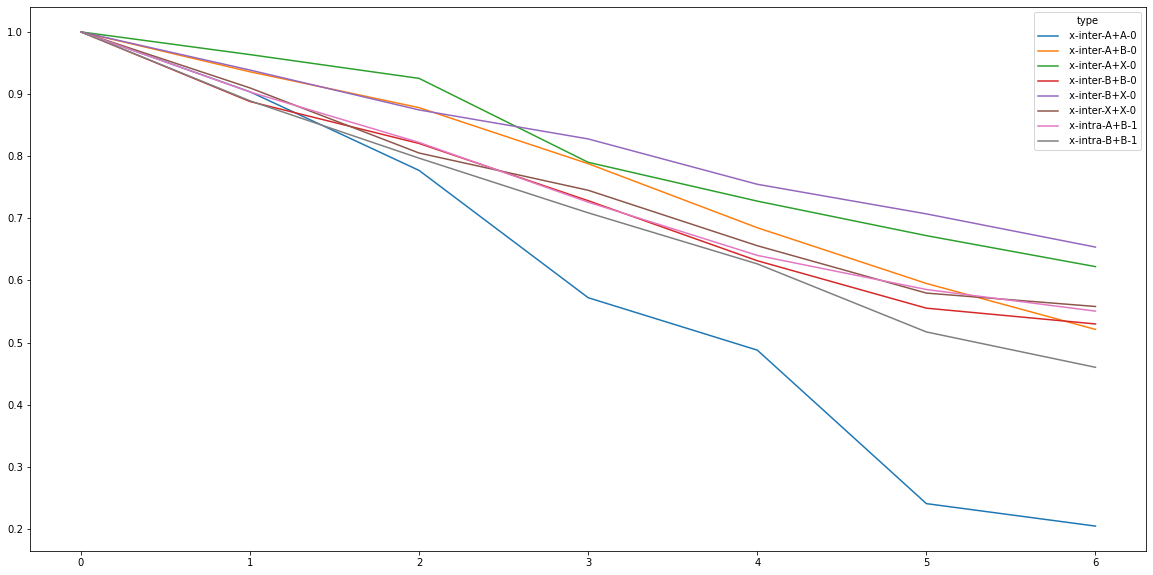

In [46]:
by_type.plot.line(figsize=(20,10))